In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve

import nltk
from nltk.corpus import stopwords
from textblob import Word

nltk.download('stopwords')
nltk.download('wordnet')

from termcolor import colored
from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Загрузка данных
train_set = pd.read_csv("./train.csv", encoding="utf-8", engine="python")
test_set = pd.read_csv("./test.csv", encoding="utf-8", engine="python")

In [4]:
# Предобработка текстов
def preprocess_text(text):
    text = text.lower()
    text = text.replace('[^\w\s]', '')
    text = text.replace('\d', '')
    text = ' '.join([Word(word).lemmatize() for word in text.split() if word not in sw])
    return text

In [5]:
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(preprocess_text)
test_set['tweet'] = test_set['tweet'].apply(preprocess_text)

In [6]:
# Разделение данных
train_x, test_x, train_y, test_y = train_test_split(train_set["tweet"], train_set["label"], test_size=0.20, random_state=11)

In [7]:
# Векторизация текста
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(train_x)
x_test_count = vectorizer.transform(test_x)

In [8]:
tf_idf_word_vectorizer = TfidfVectorizer()
x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [9]:
# Определение модели с помощью PyTorch
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [10]:
input_dim = x_train_count.shape[1]
output_dim = 1
hidden_dim = 128

In [11]:
model = SimpleClassifier(input_dim, hidden_dim, output_dim)

In [12]:
# Конвертация разреженных матриц в формат torch.sparse
x_train_count = torch.tensor(x_train_count.toarray(), dtype=torch.float32)
x_test_count = torch.tensor(x_test_count.toarray(), dtype=torch.float32)

In [13]:
# Обучение модели с помощью PyTorch
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train_count)
    loss = criterion(outputs, torch.tensor(train_y.values, dtype=torch.float32).unsqueeze(1))
    loss.backward()
    optimizer.step()

In [19]:
def evaluate_model(model, x, y):
    with torch.no_grad():
        model.eval()
        outputs = model(x)
        predicted_labels = torch.round(torch.sigmoid(outputs))
        accuracy = (predicted_labels == y.unsqueeze(1)).sum().item() / len(y)
    return accuracy

In [20]:
train_accuracy = evaluate_model(model, x_train_count, torch.tensor(train_y.values, dtype=torch.float32))
test_accuracy = evaluate_model(model, x_test_count, torch.tensor(test_y.values, dtype=torch.float32))

In [21]:
print("Точность на обучающем наборе:", train_accuracy)
print("Точность на тестовом наборе:", test_accuracy)

Точность на обучающем наборе: 0.9516810369770268
Точность на тестовом наборе: 0.9453830131913908


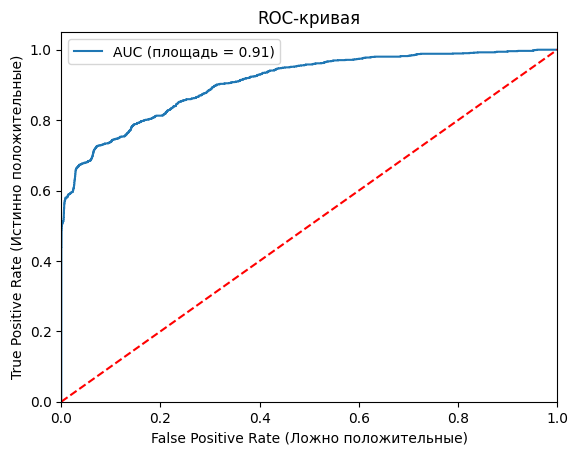

In [24]:
# Вычисление ROC-кривой и вывод графика
y = train_y
X = x_train_count
model.eval()
outputs = model(X)
logit_roc_auc = roc_auc_score(y, torch.sigmoid(outputs).detach().numpy())
fpr, tpr, thresholds = roc_curve(y, torch.sigmoid(outputs).detach().cpu().numpy())
plt.figure()
plt.plot(fpr, tpr, label='AUC (площадь = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Ложно положительные)')
plt.ylabel('True Positive Rate (Истинно положительные)')
plt.title('ROC-кривая')
plt.legend()
plt.show()